# Tentativa de análise estatística inferencial de dados econômicos do Brasil

### Info:
- https://www.ibge.gov.br/explica/inflacao.php 

### Dados analizados:
- https://sidra.ibge.gov.br/tabela/1737
- https://dados.gov.br/dataset/dolar-americano-usd-todos-os-boletins-diarios

In [1]:
# importação das bibliotecas principais
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

path = 'dados'
filename = {'ipca mensal':'IPCA - Variação mensal', 'ipca acumulado':'IPCA - Variação acumulada em 12 meses', 'dolar':'Cotação do Dólar'}

#### Tratamento do arquivo original para um arquivo csv (executado apenas uma vez):

In [88]:
mes_num = {
    'janeiro':'01', 'fevereiro':'02', 'março':'03', 
    'abril':'04','maio':'05', 'junho':'06', 
    'julho':'07', 'agosto':'08', 'setembro':'09', 
    'outubro':'10', 'novembro':'11', 'dezembro':'12'
}
def month_to_num(text):
    m, y = text.split(' ')
    return mes_num[m]+'-'+y

df0 = pd.read_csv(os.path.join(path, filename['ipca mensal']+'.tsv'), sep='\t', names=['mês', 'valor']).replace('...', np.nan)
df0['mês'] = df0['mês'].apply(month_to_num)
df0.to_csv(os.path.join(path, filename['ipca mensal']+'.csv'), index=False)

df1 = pd.read_csv(os.path.join(path, filename['ipca acumulado']+'.tsv'), sep='\t', names=['mês', 'valor']).replace('...', np.nan)
df1['mês'] = df1['mês'].apply(month_to_num)
df1.to_csv(os.path.join(path, filename['ipca acumulado']+'.csv'), index=False)

In [3]:
df2 = pd.read_csv(os.path.join(path, filename['dolar']+'.csv'))
f = lambda x: float(x.replace(',', '.'))
g = lambda x: datetime.strftime(datetime.strptime(x.split(' ')[0], '%Y-%m-%d'), '%d-%m-%Y')
df2['cotacaoCompra'] = df2['cotacaoCompra'].apply(f)
df2['cotacaoVenda'] = df2['cotacaoVenda'].apply(f)
df2['dataHoraCotacao'] = df2['dataHoraCotacao'].apply(g)
df2.rename(columns={'cotacaoCompra':'compra', 'cotacaoVenda':'venda', 'dataHoraCotacao':'data'}).to_csv(os.path.join(path, filename['dolar']+'.csv'), index=False)

#### Para facilitar a análise os dados serão armazenados no formato de vetor (numpy array).
 - A variável `month` armazena as datas para ter referência.

In [21]:
ipca_mensal = pd.read_csv(os.path.join(path, filename['ipca mensal'])+'.csv').to_numpy().T[1]
month, ipca_acum = pd.read_csv(os.path.join(path, filename['ipca acumulado'])+'.csv').to_numpy().T
month = list(month)

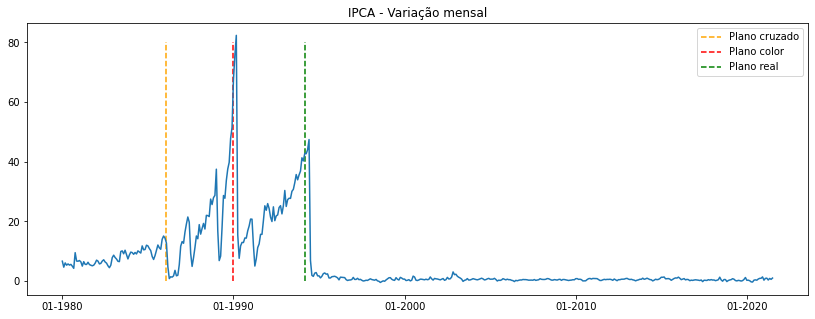

In [22]:
x, xt = [], []
for t in range(0, len(ipca_mensal), 120):
    x.append(t)
    xt.append(month[t])

i = 3
plt.figure(figsize=(14, 5))
plt.title('IPCA - Variação mensal')
plt.vlines(month.index('02-1986'), 0, 80, color='orange', linestyles='dashed', label='Plano cruzado')
plt.vlines(month.index('01-1990'), 0, 80, color='r', linestyles='dashed', label='Plano color')
plt.vlines(month.index('03-1994'), 0, 80, color='g', linestyles='dashed', label='Plano real')
plt.plot(ipca_mensal)
plt.xticks(x, xt)
plt.legend()
plt.show()

In [ ]:
df1 = pd.read_csv(os.path.join(path, filename['dolar'])+'.csv')
df1

- **Analisando os dos valores da cotação, temos:**

In [ ]:
difcot = df1['compra'] - df1['venda'] # diferença entre a cotação de compra e cotação de venda
print('Média:', np.mean(difcot))
print('Média da diferença absoluta:', np.mean(abs(difcot)))
print('Mediana:', np.median(difcot))
print('Variância:', np.var(difcot))
print('Desvio padrão:', np.std(difcot))
plt.plot(difcot)
plt.show()

Pode-se observar que os valores, no geral, tem pouca variação. Logo, para a análise, será tomado a média dos valores em torno da data. Para relacionar os dados será tomado a média mensal da cotação.

In [27]:
%%time
f_mstf = lambda x: '-'.join(x.split('-')[1:])
month_cot = [f_mstf(m) for m in df1['data']]
cot_data = []
for M in month:
    val = []
    for i, m in enumerate(month_cot):
        if m == M: val.append((df1.iloc[i]['compra'] + df1.iloc[i]['venda'])/2)
    cot_data.append(np.nan if not len(val) else np.mean(val))
cot_data = np.array(cot_data)

Wall time: 13.9 s


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].plot(cot_data)
axs[1].plot(range(200, len(cot_data)), cot_data[200:])
plt.show()

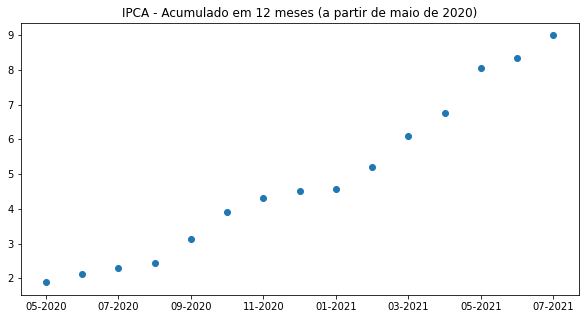

In [122]:
t = month.index('05-2020')
x, xs = [], []
for i in range(t, len(month), 2):
    x.append(i)
    xs.append(month[i])

plt.figure(figsize=(10,5))
plt.title('IPCA - Acumulado em 12 meses (a partir de maio de 2020)')
plt.plot(np.arange(t, len(month)), ipca_acum[t:], 'o')
plt.xticks(x, xs)
plt.show()

Como pode ser observado acima, as variações dos preços vem crescendo desde maio de 2020. Logo, podemos análisar se existe uma relação linear entre o tempo decorrido (em meses) e o valor dos dados usando o *coeficiente de correlação linear*.
\\[r = \dfrac{n\sum{xy} - (\sum{x})(\sum{y})}{\sqrt{n\sum{x^2} - (\sum{x})^2}\sqrt{n\sum{y^2} - (\sum{y})^2}} \\]

In [112]:
# calculando o coeficiente de correlação linear
X = np.arange(t, len(month))
Y = ipca_acum[t:]
n = len(X)
r = (n*np.sum(X*Y) - np.sum(X)*np.sum(Y))/((n*np.sum(X**2) - np.sum(X)**2)**0.5 * (n*np.sum(Y**2) - np.sum(Y)**2)**0.5)
r

0.98126980391741

Como o coeficiente de correlação linear se verificou alto, podemos aplicar um modelo de regreção linear, sendo

\\[Y = mX + b\\]

\\[m = \dfrac{\sum{(x - \bar{x})(y - \bar{y})}}{\sum{(x - \bar{x})^2}}\\]

\\[b = \bar{Y} - m\bar{X}\\]

In [113]:
#m = (n*np.sum(X*Y) - np.sum(X)*np.sum(Y))/(n*np.sum(X**2) - np.sum(X)**2)
m = np.sum((X - np.mean(X))*(Y - np.mean(Y)))/np.sum((X - np.mean(X))**2)
b = np.mean(Y) - m*np.mean(X)
f = lambda x: m*x + b
print(m, b)

0.5171785714285715 -249.09001190476195


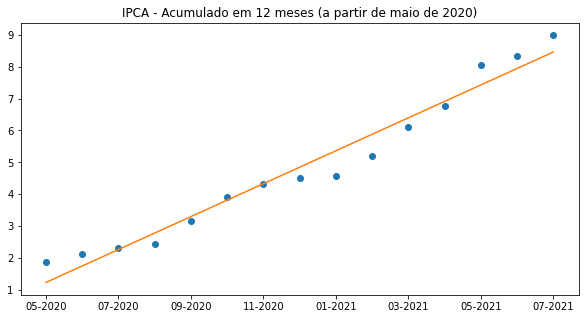

In [120]:
t = month.index('05-2020')
x, xs = [], []
for i in range(t, len(month), 2):
    x.append(i)
    xs.append(month[i])
    
X = np.arange(t, len(month))
Y = ipca_acum[t:]

plt.figure(figsize=(10,5))
plt.title('IPCA - Acumulado em 12 meses (a partir de maio de 2020)')
plt.plot(X, Y, 'o')
plt.plot(X, f(X))
plt.xticks(x, xs)
plt.show()

In [115]:
np.mean(ipca_mensal[t:])

0.5926666666666667

A partir do cálculo do coeficiente angular calculado podemos concluir que, desde maio de 2020, a variação do valor é de aproximadamente `0.5`, e isso pode ser confirmado através da média da variação mensal, que é aproximadamente `0.59`. Portanto, podemos calcular o *erro quadrático médio* entre o valor real e o valor estimado, como

\\[\epsilon = \frac{1}{n}\sum{(\hat{\theta} - \theta)^2}\\]

In [117]:
e = np.sum((Y - f(X))**2)/n
e

0.19242296031746334